In [12]:
from optimize import optimize
from signals import compute_features, detect_trade_signals
from multibacktest import MultiBacktester

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
## commodity prices ##
commodities = pd.read_csv('../Data/raw/commodity_prices.csv',index_col=['Date'])
commodities.index = pd.to_datetime(commodities.index)

## stock prices ##
stocks = pd.read_csv('../Data/raw/stock_prices.csv',index_col=['Date'])
stocks.index = pd.to_datetime(stocks.index)


# Personal Projects/commodity/Data/raw/commodity_prices.csv

prices = commodities.merge(stocks, left_index=True, right_index=True)

### Choose Stocks and Commodity

In [ ]:
#### stocks
chosen_stocks = stocks.iloc[:,[7,9]]
stock_names = list(chosen_stocks.columns)

prices_dict = {
    stock_names[0]:chosen_stocks.iloc[:,[0]],
    stock_names[1]:chosen_stocks.iloc[:,[1]]
}

#### commodity
commodity = prices['GC=F Close']

##### Optimize to find best metrics

In [90]:
### Choose Stocks ###
stock1 = chosen_stocks[stock_names[0]]
stock2 = chosen_stocks[stock_names[1]]

### Param Grids ###
param_grid = {
    'threshold': np.linspace(0.2,1,20),
    'streak': [3,5,7],
    'quantile': np.linspace(0.2,1,20),
    'lag': [1,5,10],
    'window': [7,9,14]
}


### Optimize Stocks ###
stock1_opt = optimize(commodity, stock1, param_grid)
stock2_opt = optimize(commodity, stock2, param_grid)

#### find features and signals

In [91]:
### get best parameters for each stock
stock1_best_params = stock1_opt.iloc[0]
stock2_best_params = stock2_opt.iloc[0]


### Compute stock 1 features
stock1_features = compute_features(
    commodity, 
    stock1, 
    window=int(stock1_best_params['window']), 
    lag=stock1_best_params['lag'])

stock1_signals = detect_trade_signals(
    stock1_features,
    threshold=stock1_best_params['threshold'],
    min_streak=int(stock1_best_params['streak']),
    quantile=stock1_best_params['quantile'],
)


### Compute stock 2 features
stock2_features = compute_features(
    commodity, 
    stock2, 
    window=int(stock2_best_params['window']), 
    lag=stock2_best_params['lag'])

stock2_signals = detect_trade_signals(
    stock2_features,
    threshold=stock2_best_params['threshold'],
    min_streak=int(stock2_best_params['streak']),
    quantile=stock2_best_params['quantile'],
)

### Create signals dict
signals_dict = {
    stock_names[0]:stock1_signals.loc[: ,['trade_signal']],
    stock_names[1]:stock2_signals.loc[: ,['trade_signal']]
}

#### Let's test multi-backtester

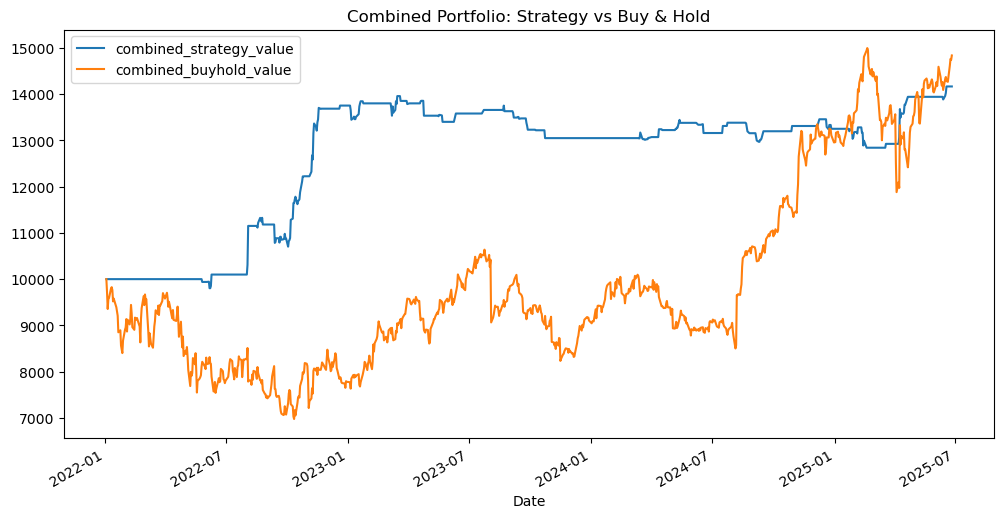

In [92]:
mt = MultiBacktester(
    prices_dict = prices_dict,
    signals_dict = signals_dict,
    starting_capital = 10_000
)

result = mt.run()

result[['combined_strategy_value', 'combined_buyhold_value']].plot(
    figsize=(12, 6), title="Combined Portfolio: Strategy vs Buy & Hold"
)
plt.show()


In [93]:
result.tail(10)

,CSCO_strategy,CSCO_buyhold,FTNT_strategy,FTNT_buyhold,combined_strategy_return,combined_buyhold_return,combined_strategy_value,combined_buyhold_value
Date,,,,,,,,
2025-06-12,0.0,0.014177,-0.000000,-0.003529,0.000000,0.005324,13942.331975,14260.004916
2025-06-13,-0.0,-0.015515,-0.008164,-0.008164,-0.004082,-0.011840,13885.415977,14091.172777
2025-06-16,0.0,0.022156,0.011108,0.011108,0.005554,0.016632,13962.533888,14325.538508
2025-06-17,-0.0,-0.002748,0.009122,0.009122,0.004561,0.003187,14026.217856,14371.197189
2025-06-18,0.0,0.007806,0.020023,-0.020023,0.010012,-0.006108,14166.643475,14283.411676
2025-06-20,0.0,0.007290,-0.000000,-0.009621,0.000000,-0.001165,14166.643475,14266.766740
2025-06-23,0.0,0.015983,0.000000,0.033050,0.000000,0.024516,14166.643475,14616.535650
2025-06-24,0.0,0.007569,0.000000,0.012312,0.000000,0.009941,14166.643475,14761.832621
2025-06-25,0.0,0.004419,-0.000000,-0.006991,0.000000,-0.001286,14166.643475,14742.848910
